In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
from tqdm.notebook import tqdm
import datetime
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

In [ ]:
# Load train data
DATA_PATH = './datasets/'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_df.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_df.csv'))

In [4]:
train_df.head(2)

,ID,month,B1_mean,B1_std,B1_min,B1_max,B1_median,B2_mean,B2_std,B2_min,...,vis_swir_ratio,LAI_approx,TCARI,MCARI2,WDRVI,MTVI2,CCCI,B8_B11_B4,B8_B11_B2,texture_homogeneity
0,ID_ZUfp59_Jan,Jan,3119.697,593.1587,2584.0,4595.0,2810.0,2963.4856,760.8518,2267.0,...,0.857228,-13.389297,525.596848,0.358802,-0.724257,0.358802,0.858681,0.000414,0.000388,0.000374
1,ID_KfCbOO_Jan,Jan,4412.240,496.0062,3406.0,5444.0,4367.0,4380.4610,642.4509,2979.0,...,0.941388,-16.083742,-302.758152,0.057786,-0.797462,0.057786,1.128000,0.000218,0.000227,0.000395


In [5]:
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (7433, 160)
Test shape: (2201, 157)


In [6]:
# print cols  in train df and not in test_df

train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

cols_in_train_not_in_test = train_cols - test_cols
cols_in_train_not_in_test

{'Crop', 'Crop_encoded', 'class'}

### Model Training and Features Selection

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()

# Features and labels
feature_cols = [col for col in train_df.columns if col not in ['ID', 'month', 'Crop', 'Crop_encoded', 'class', 'base_id', 'submission_id', '']]
print(f"\nNumber of features: {len(feature_cols)}")


def handle_outliers(df, cols, method='clip', threshold=3):
    """Handle outliers in the dataset"""
    df_processed = df.copy()

    for col in cols:
        if method == 'clip':
            # Clip values beyond 3 standard deviations
            mean, std = df[col].mean(), df[col].std()
            df_processed[col] = df[col].clip(lower=mean - threshold * std,
                                            upper=mean + threshold * std)

    return df_processed

# Apply outlier handling to numerical features
train_df = handle_outliers(train_df, feature_cols)
test_df = handle_outliers(test_df, feature_cols)

X = train_df[feature_cols]
y = train_df['Crop_encoded']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y,random_state=SEED)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Scale features
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_df[feature_cols])


Number of features: 153


In [8]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss, f1_score, classification_report
import numpy as np

# Extract base_id from ID column
# Assuming train_df has an 'ID' column in format 'ID_baseID_month'
train_df['base_id'] = train_df['ID'].str.split('_').str[1]

# Best trial parameters from Optuna
lgb_params = {'boosting_type': 'gbdt',
 'learning_rate': 0.018532192293412842,
 'num_leaves': 154,
 'max_depth': 7,
 'feature_fraction': 0.9116533879586213,
 'min_data_in_leaf': 25,
 'lambda_l1': 0.011908305294124163,
 'lambda_l2': 1.0474921105080416e-06,
 'min_gain_to_split': 0.06283015568879952,
 'bagging_fraction': 0.8583593350618955,
 'bagging_freq': 5,
 'objective': 'multiclass',
 'num_class': 3,
 'metric': 'multi_logloss',
 'verbose': -1,
 'random_state': 42}

# Cross-validation with GroupKFold
# This ensures samples from the same base_id stay in the same fold
print("\n\nTraining with Group K-Fold Cross Validation (grouped by base_id)...")
n_folds = 5

# Create groups based on base_id
groups = train_df['base_id'].values

# Initialize GroupKFold
gkf = GroupKFold(n_splits=n_folds)

# Lists to store metrics
cv_scores = []
f1_macro_scores = []
models = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y, groups=groups)):
    print(f"\nFold {fold + 1}/{n_folds}")

    # Get the data for this fold
    X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)

    # Train the model
    model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=500,
        valid_sets=[val_data],
        valid_names=['val'],
        callbacks=[lgb.early_stopping(50)]
    )

    # Make predictions
    y_pred_proba = model.predict(X_val_fold)
    y_pred_class = np.argmax(y_pred_proba, axis=1)

    # Calculate metrics
    loss = log_loss(y_val_fold, y_pred_proba)
    f1_macro = f1_score(y_val_fold, y_pred_class, average='macro')

    # Store metrics
    cv_scores.append(loss)
    f1_macro_scores.append(f1_macro)
    models.append(model)

    # Print fold results
    print(f"Fold {fold+1} - Log Loss: {loss:.4f}, F1 (macro): {f1_macro:.4f}")

# Print average results
print("\nCross-Validation Results:")
print(f"Average Log Loss: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Average F1 (macro): {np.mean(f1_macro_scores):.4f} ± {np.std(f1_macro_scores):.4f}")

# You can use the best model or ensemble all models for final predictions
best_model_idx = np.argmin(cv_scores)
best_model = models[best_model_idx]
print(f"\nBest model is from fold {best_model_idx+1} with Log Loss: {cv_scores[best_model_idx]:.4f}")



Training with Group K-Fold Cross Validation (grouped by base_id)...

Fold 1/5
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	val's multi_logloss: 0.33075
Fold 1 - Log Loss: 0.3307, F1 (macro): 0.8745

Fold 2/5
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	val's multi_logloss: 0.309494
Fold 2 - Log Loss: 0.3095, F1 (macro): 0.8928

Fold 3/5
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[496]	val's multi_logloss: 0.393271
Fold 3 - Log Loss: 0.3933, F1 (macro): 0.8523

Fold 4/5
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	val's multi_logloss: 0.370058
Fold 4 - Log Loss: 0.3701, F1 (macro): 0.8538

Fold 5/5
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	va

### Model Evaluation

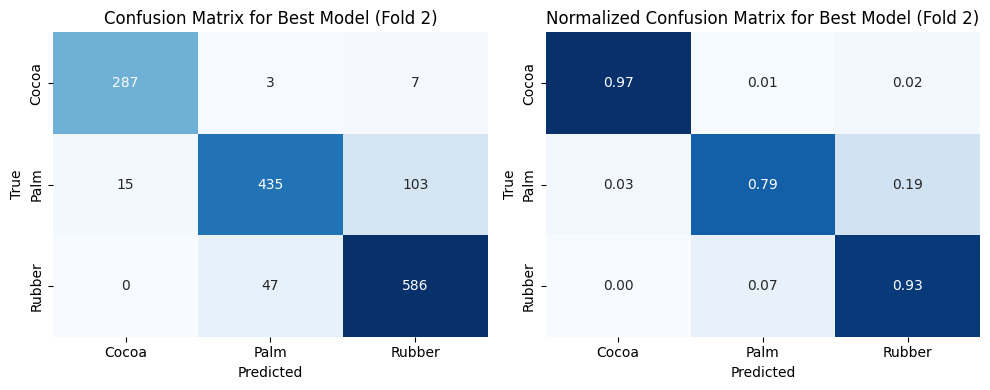


Log Loss for Best Model (Fold 2): 0.3095

F1 Score (macro) for Best Model (Fold 2):  0.8928

Confusion Matrix:
[[287   3   7]
 [ 15 435 103]
 [  0  47 586]]

Classification Report for Best Model (Fold 2):
              precision    recall  f1-score   support

       Cocoa       0.95      0.97      0.96       297
        Palm       0.90      0.79      0.84       553
      Rubber       0.84      0.93      0.88       633

    accuracy                           0.88      1483
   macro avg       0.90      0.89      0.89      1483
weighted avg       0.88      0.88      0.88      1483



In [9]:
# Get predictions from the best model
best_fold_idx = np.argmin(cv_scores)
best_model = models[best_fold_idx]

# Get the validation data from the best fold
# We need to recreate the GroupKFold split to get the validation indices
gkf_list = list(gkf.split(X_scaled, y, groups=groups))
_, val_indices = gkf_list[best_fold_idx]
X_val_best = X_scaled[val_indices]
y_val_best = y[val_indices]

# Make predictions
y_pred_proba = best_model.predict(X_val_best)
y_pred = np.argmax(y_pred_proba, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_val_best, y_pred)

# Define class names
class_names = ['Cocoa', 'Palm', 'Rubber']

# Combined plots
plt.figure(figsize=(10, 4))

# Confusion matrix plot
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for Best Model (Fold {best_fold_idx+1})')

# Normalized confusion matrix plot
plt.subplot(1, 2, 2)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Normalized Confusion Matrix for Best Model (Fold {best_fold_idx+1})')
plt.tight_layout()
plt.show()

# Print the score
print(f"\nLog Loss for Best Model (Fold {best_fold_idx+1}): {log_loss(y_val_best, y_pred_proba):.4f}")
print(f"\nF1 Score (macro) for Best Model (Fold {best_fold_idx+1}): {f1_score(y_val_best, y_pred, average='macro'): .4f}")

# Print classification metrics for the best model
print("\nConfusion Matrix:")
print(cm)

print(f"\nClassification Report for Best Model (Fold {best_fold_idx+1}):")
print(classification_report(y_val_best, y_pred, target_names=class_names))

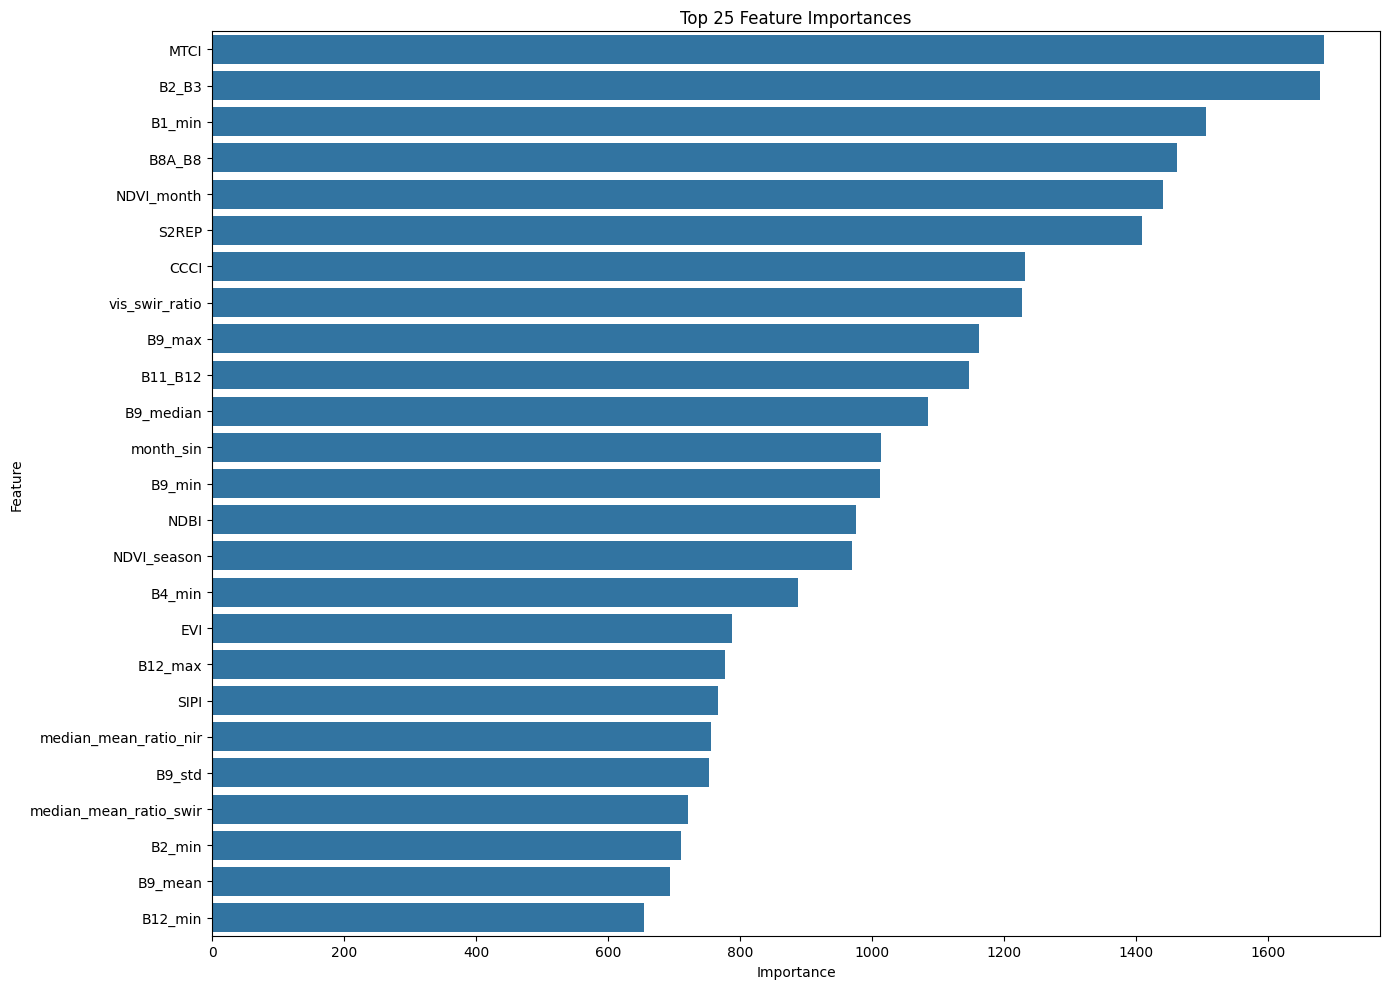

In [10]:
# Feature importance
feature_cols = X_train.columns
plt.figure(figsize=(14, 10))
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importance()
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
top_features = feature_importance.head(25)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 25 Feature Importances')
plt.tight_layout()
plt.show()

### Hyperparameter Optimization

In [11]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.6 MB/s eta 0:00:00


In [12]:
# import optuna
# import lightgbm as lgb
# import numpy as np
# from sklearn.metrics import log_loss, f1_score
# from sklearn.model_selection import GroupKFold

# def objective(trial):
#     # First determine boosting type
#     boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])

#     # Base parameters
#     params = {
#         'objective': 'multiclass',
#         'num_class': 3,
#         'metric': 'multi_logloss',
#         'boosting_type': boosting_type,
#         'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#         'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
#         'verbose': -1,
#         'random_state': SEED
#     }

#     # Add bagging parameters only for gbdt and dart
#     if boosting_type != 'goss':
#         params['bagging_fraction'] = trial.suggest_float('bagging_fraction', 0.5, 1.0)
#         params['bagging_freq'] = trial.suggest_int('bagging_freq', 1, 10)
#     else:
#         # GOSS-specific parameters
#         params['top_rate'] = trial.suggest_float('top_rate', 0.1, 0.5)
#         params['other_rate'] = trial.suggest_float('other_rate', 0.05, 0.5)

#     # Use GroupKFold for cross-validation
#     n_folds = 5
#     gkf = GroupKFold(n_splits=n_folds)
#     groups = train_df['base_id'].values

#     # Lists to store metrics
#     f1_macro_scores = []
#     logloss_scores = []

#     # Cross-validation
#     for train_idx, val_idx in gkf.split(X_scaled, y, groups=groups):
#         X_train_fold, X_val_fold = X_scaled[train_idx], X_scaled[val_idx]
#         y_train_fold, y_val_fold = y[train_idx], y[val_idx]

#         # Create LightGBM datasets
#         train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
#         val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)

#         # Train the model
#         model = lgb.train(
#             params,
#             train_data,
#             num_boost_round=1000,
#             valid_sets=[val_data],
#             valid_names=['val'],
#             callbacks=[lgb.early_stopping(50)]
#         )

#         # Make predictions
#         y_pred_proba = model.predict(X_val_fold)
#         y_pred_class = np.argmax(y_pred_proba, axis=1)

#         # Calculate metrics
#         f1_macro = f1_score(y_val_fold, y_pred_class, average='macro')
#         logloss = log_loss(y_val_fold, y_pred_proba)

#         f1_macro_scores.append(f1_macro)
#         logloss_scores.append(logloss)

#     # Calculate average scores
#     avg_f1_macro = np.mean(f1_macro_scores)
#     avg_logloss = np.mean(logloss_scores)

#     # Store both metrics as user attributes
#     trial.set_user_attr('f1_macro', float(avg_f1_macro))
#     trial.set_user_attr('logloss', float(avg_logloss))

#     # Print trial results
#     print(f"Trial {trial.number}:")
#     print(f"  F1 Score (macro): {avg_f1_macro:.4f}")
#     print(f"  Log Loss: {avg_logloss:.4f}")
#     print(f"  Boosting Type: {boosting_type}")

#     # Return negative F1 score since Optuna minimizes by default
#     return -avg_f1_macro

# # Create and run Optuna study with more trials
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # Start with fewer trials for testing

# # Print best parameters and scores
# print("\nBest trial:")
# trial = study.best_trial
# print(f"  F1 Score (macro): {-trial.value:.4f}")
# print(f"  Log Loss: {trial.user_attrs['logloss']:.4f}")
# print("  Parameters:")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

In [13]:
# # Use the best parameters to train the final model
# best_params = trial.params.copy()
# best_params.update({
#     'objective': 'multiclass',
#     'num_class': 3,
#     'metric': 'multi_logloss',
#     'verbose': -1,
#     'random_state': SEED
# })

# {'boosting_type': 'gbdt',
#  'learning_rate': 0.018532192293412842,
#  'num_leaves': 154,
#  'max_depth': 7,
#  'feature_fraction': 0.9116533879586213,
#  'min_data_in_leaf': 25,
#  'lambda_l1': 0.011908305294124163,
#  'lambda_l2': 1.0474921105080416e-06,
#  'min_gain_to_split': 0.06283015568879952,
#  'bagging_fraction': 0.8583593350618955,
#  'bagging_freq': 5,
#  'objective': 'multiclass',
#  'num_class': 3,
#  'metric': 'multi_logloss',
#  'verbose': -1,
#  'random_state': 42}

### Make predictions

In [14]:
# 1. Create an ensemble of all fold models
def ensemble_predict(models, X, weights=None):
    if weights is None:
        weights = np.ones(len(models)) / len(models)

    preds = np.zeros((X.shape[0], 3))
    for model, weight in zip(models, weights):
        preds += weight * model.predict(X)

    return preds / np.sum(weights)

# Calculate weights based on validation performance
weights = 1.0 / np.array(cv_scores)
weights = weights / np.sum(weights)

test_df['base_id'] = test_df['ID'].str.split('_').str[1]

# Make ensemble predictions
ensemble_preds = ensemble_predict(models, test_scaled, weights)
test_df['prediction'] = np.argmax(ensemble_preds, axis=1)
test_df['prediction_label'] = test_df['prediction'].map({0: 'Cocoa', 1: 'Palm', 2: 'Rubber'})

# 2. Improve prediction aggregation with probability-weighted voting
test_df['prob_cocoa'] = ensemble_preds[:, 0]
test_df['prob_palm'] = ensemble_preds[:, 1]
test_df['prob_rubber'] = ensemble_preds[:, 2]

# Aggregate by averaging probabilities instead of majority vote
agg_probs = test_df.groupby('base_id')[['prob_cocoa', 'prob_palm', 'prob_rubber']].mean()
agg_probs['prediction'] = np.argmax(agg_probs.values, axis=1)
agg_probs['prediction_label'] = agg_probs['prediction'].map({0: 'Cocoa', 1: 'Palm', 2: 'Rubber'})

# Create submission file with probability-weighted predictions
new_submission = pd.DataFrame({
    'ID': 'ID_' + agg_probs.index.astype(str),
    'Target': agg_probs['prediction_label']
}).reset_index(drop=True)

new_submission.head()

,ID,Target
0,ID_000167,Rubber
1,ID_004157,Palm
2,ID_010554,Palm
3,ID_016218,Rubber
4,ID_018928,Cocoa


In [ ]:
# Post Processing
manual_fixes = {
    'ID_000167': 'Palm',
    'ID_034755': 'Rubber',
    'ID_046027': 'Rubber',
    'ID_052303': 'Palm',
    'ID_093703': 'Palm',
    'ID_142344': 'Rubber',
    'ID_150354': 'Rubber',
    'ID_159914': 'Cocoa',
    'ID_237616': 'Palm',
    'ID_330973': 'Cocoa',
    'ID_403846': 'Cocoa',
    'ID_407489': 'Palm',
    'ID_416894': 'Palm',
    'ID_461979': 'Rubber',
    'ID_477534': 'Palm',
    'ID_601498': 'Cocoa',
    'ID_665410': 'Rubber',
    'ID_676417': 'Palm',
    'ID_677850': 'Rubber',
    'ID_687086': 'Rubber',
    'ID_719275': 'Rubber',
    'ID_721602': 'Rubber',
    'ID_877892': 'Rubber',
    'ID_885419': 'Rubber',
    'ID_890388': 'Palm',
    'ID_906513': 'Rubber',
    'ID_907959': 'Palm',
    'ID_908925': 'Cocoa',
    'ID_909791': 'Rubber'
}

# Apply manual fixes safely
new_submission.loc[
    new_submission['ID'].isin(manual_fixes.keys()),
    'Target'
] = new_submission['ID'].map(manual_fixes)

In [16]:
new_submission.shape

(282, 2)

In [17]:
print(new_submission.Target.value_counts())
new_submission.to_csv('new_submission.csv', index=False)
print("Submission saved to 'new_submission.csv'")

Target
Rubber    118
Palm      107
Cocoa      57
Name: count, dtype: int64
Submission saved to 'new_submission.csv'


In [18]:
'ID_906513' in new_submission['ID'].values

True

In [20]:
# Create file
from google.colab import files
new_submission.to_csv('new_submission.csv', index=False)
files.download('new_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>